# Config

In [2]:
# Libraries
import planetary_computer
import pystac_client
import stackstac
import rasterio.plot
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import geopandas as gpd

In [3]:
# Params
# Define bounding box (lon/lat) change this as necessary - per pilot? per city?
bbox = [2.10, 41.35, 2.25, 41.45]


# Get data

In [4]:
# Connect to Planetary Computer STAC
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Search Sentinel-2 L2A - dates can be adjusted as necessary
search = catalog.search(
    collections=["sentinel-2-l2a"], # Sentinel-2 Level 2A collection
    bbox=bbox,
    datetime="2025-01-01/2025-07-31", # adjust dates as necessary
    query={"eo:cloud_cover": {"lt": 10}} # filter for low cloud cover
)

items = [planetary_computer.sign(item) for item in search.items()] # Sign items for access (neccesary for selecting viable data)

# Data management (Code)

In [5]:
# Stack and compute NDVI
stack = stackstac.stack(items, assets=["B04", "B08"], bounds_latlon=bbox, epsg=4326) # Load the bands into dask array
red = stack.sel(band="B04").mean("time")
nir = stack.sel(band="B08").mean("time")
ndvi = (nir - red) / (nir + red) # NDVI calculation
ndvi_local = ndvi.compute()


In [6]:
# Convert to DataFrame for further analysis
df = ndvi_local.to_dataframe().reset_index() 
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs="EPSG:4326")
gdf.rename(columns={'stackstac-7887cd02cc986d358722ff5aec6a848d': 'NDVI'}, inplace=True)


# Plots

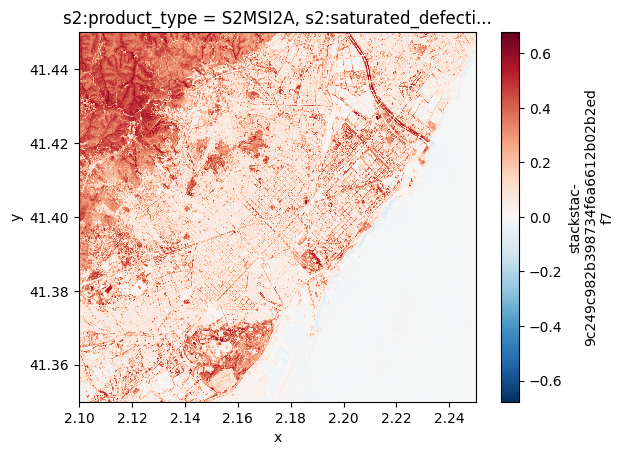

In [7]:
# Plots and visualizations
ndvi.plot() # Visualize NDVI

# Save results

In [8]:
#Save results and figures
# gdf.to_file("../data/interim/ndvi_data.geojson") 
gdf.to_parquet("../data/interim/ndvi_data.parquet")